In [ ]:
!nvidia-smi

Sat Mar 14 12:22:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 435.21       Driver Version: 435.21       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 980     Off  | 00000000:01:00.0  On |                  N/A |
| 28%   39C    P8    15W / 180W |    354MiB /  4040MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *
from fastai2.medical.imaging import *

import pydicom

import pandas as pd

In [ ]:
from nbdev.showdoc import *

# Tutorial - Classification of thoracic X-rays

> In this tutorial we will build a classifier that distinguishes between chest X-rays with pneumothorax and without pneumothorax. The image data is loaded directly from the DICOM source files, so no prior DICOM data handling is needed.

## Import X-rays

### Loading the data with `Datasets`

To analyze our dataset, we load the paths to the DICOM files with `get_dicom_files`. Then we can load the DICOM file with `dcmread` and plot it with `show`.

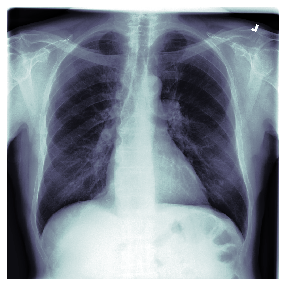

In [ ]:
#pneumothorax_source = Path("/home/moritz/Documents/siim/")

# TODO: create small dataset and use the following structure:
pneumothorax_source = untar_data(URLs.SIIM_SMALL)

items = get_dicom_files(pneumothorax_source/f"train/")
trn,val = RandomSplitter()(items)

items[3].dcmread().show()

TODO: UPDATE TEXT: Then we detail the type transforms (applied to the items to form a tuple) and the dataset transforms. For our inputs we use `PILImage.create` and for our targets, the `parent_label` function to convert a filename to its class, followed by `Categorize`. We'll also map the wordnet category ids used in Imagenette to words.

The dataset transforms contain data augmentation using PIL and a resize to 128.

Next, we need to load the labels for the dataset. In this case, the labels indicate whether the xray shows a pneumothorax or not.

In [ ]:
str(pneumothorax_source)

'/home/moritz/.fastai/data/siim_small'

In [ ]:
df = pd.read_csv(pneumothorax_source/f"labels.csv")
df.head()

,file,label
0,train/No Pneumothorax/000000.dcm,No Pneumothorax
1,train/Pneumothorax/000001.dcm,Pneumothorax
2,train/No Pneumothorax/000002.dcm,No Pneumothorax
3,train/Pneumothorax/000003.dcm,Pneumothorax
4,train/Pneumothorax/000004.dcm,Pneumothorax


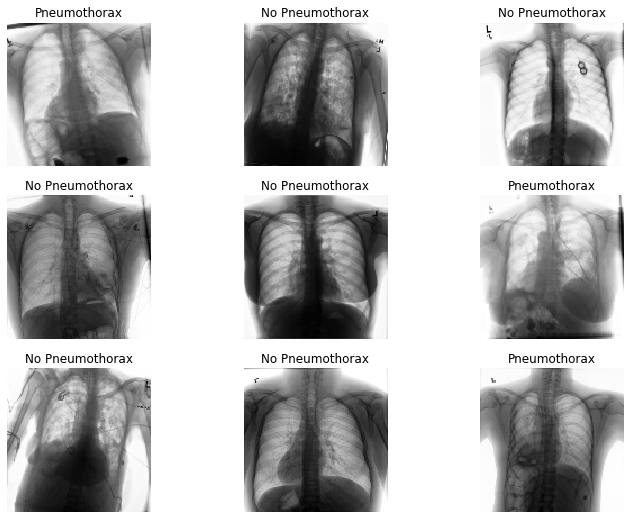

In [ ]:
pneumothorax = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
                   get_x=lambda x:pneumothorax_source/f"{x[0]}",
                   splitter=RandomSplitter(),
                   get_y=lambda x:x[1],
                   batch_tfms=aug_transforms(size=128, flip_vert=False, max_lighting=0.1, max_zoom=1.05, max_warp=0.))

dls = pneumothorax.dataloaders(df.values)
dls.show_batch(max_n=9, figsize=(12,9))

We can then pass all of this information to `Datasets`.

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,1.265875,0.899782,0.720000,00:02


In [ ]:
learn.predict(pneumothorax_source/f"train/Pneumothorax/000004.dcm")

('No Pneumothorax', tensor(0), tensor([0.9825, 0.0175]))

In [ ]:
learn.tta(use_max=True)

(tensor([[0.9995, 0.0450],
         [0.9805, 0.3947],
         [0.9958, 0.0426],
         [0.9942, 0.0445],
         [0.9505, 0.1779],
         [0.9995, 0.0075],
         [0.9625, 0.3205],
         [0.9953, 0.0605],
         [0.9111, 0.6206],
         [0.9918, 0.0736],
         [0.9899, 0.0532],
         [0.9881, 0.1633],
         [0.9975, 0.0457],
         [0.7064, 0.4587],
         [0.9909, 0.0716],
         [0.9935, 0.0754],
         [0.9638, 0.0727],
         [0.9956, 0.1266],
         [0.9926, 0.0729],
         [0.9130, 0.1725],
         [0.9767, 0.2118],
         [0.9988, 0.0230],
         [0.9718, 0.4271],
         [0.7843, 0.9696],
         [0.9706, 0.2754],
         [0.7528, 0.7825],
         [0.9472, 0.1066],
         [1.0000, 0.0137],
         [0.9987, 0.0087],
         [0.9844, 0.2250],
         [0.8197, 0.4280],
         [0.9989, 0.0879],
         [0.9900, 0.0461],
         [0.9923, 0.3142],
         [0.9736, 0.2533],
         [0.9973, 0.0380],
         [0.9983, 0.0854],
 

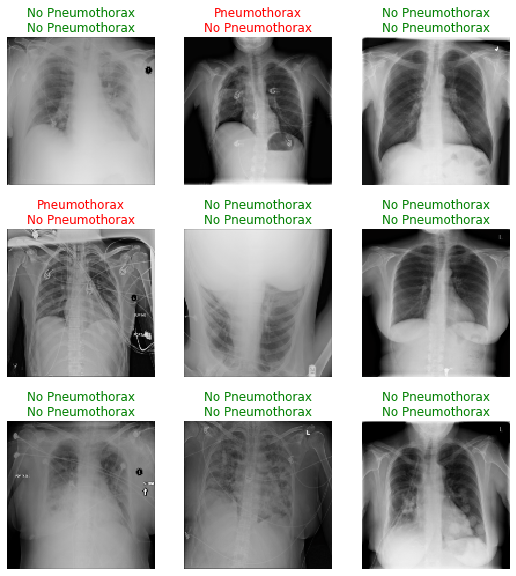

In [ ]:
learn.show_results(max_n=9)

In [ ]:
interp = Interpretation.from_learner(learn)

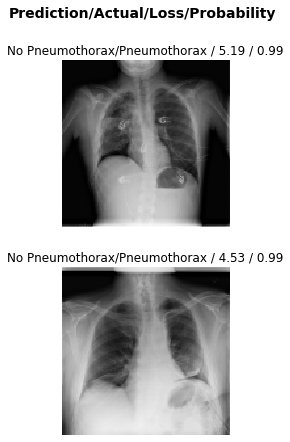

In [ ]:
interp.plot_top_losses(2)